Rafael Gonçalves (186062)

In [1]:
import os
import urllib.request
import random
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline

## Download dataset

In [2]:
train_url = 'http://www.dca.fee.unicamp.br/~lboccato/dados_treinamento.mat'
validation_url = 'http://www.dca.fee.unicamp.br/~lboccato/dados_val.mat'
test_url = 'http://www.dca.fee.unicamp.br/~lboccato/dados_teste.mat'
data_dir = os.path.abspath(os.path.relpath('../data'))
train_path = os.path.join(data_dir, 'train.mat')
validation_path = os.path.join(data_dir, 'validation.mat')
test_path = os.path.join(data_dir, 'test.mat')
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

urllib.request.urlretrieve(train_url, train_path)
urllib.request.urlretrieve(validation_url, validation_path)
urllib.request.urlretrieve(test_url, test_path)

('/home/rafael/inbox/machine-learning/3-mlp-and-svm/data/test.mat',
 <http.client.HTTPMessage at 0x7fa5004bdc88>)

In [3]:
train_set = scipy.io.loadmat(train_path)
val_set = scipy.io.loadmat(validation_path)
test_set = scipy.io.loadmat(test_path)

In [4]:
X_train = train_set["X"]
y_train = train_set["y"]
X_val = val_set["Xval"]
y_val = val_set["yval"]
X_test = test_set["Xt"]
y_test = test_set["yt"]

In [5]:
y_train[y_train == -1] = 0
y_val[y_val == -1] = 0
y_test[y_test == -1] = 0

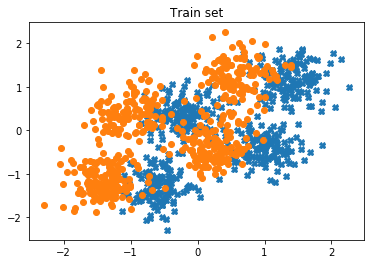

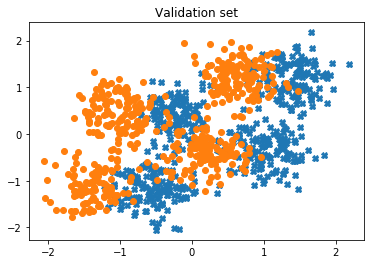

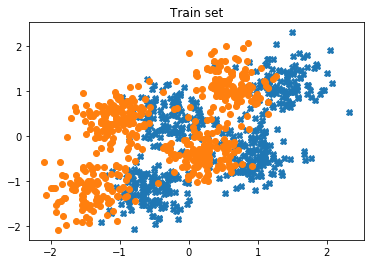

In [6]:
plt.plot(X_train[np.in1d(y_train, 1), 0], X_train[np.in1d(y_train, 1), 1], 'X')
plt.plot(X_train[np.in1d(y_train, 0), 0], X_train[np.in1d(y_train, 0), 1], 'o')
plt.title("Train set")
plt.show()
plt.plot(X_val[np.in1d(y_val, 1), 0], X_val[np.in1d(y_val, 1), 1], 'X')
plt.plot(X_val[np.in1d(y_val, 0), 0], X_val[np.in1d(y_val, 0), 1], 'o')
plt.title("Validation set")
plt.show()
plt.title("Train set")
plt.plot(X_test[np.in1d(y_test, 1), 0], X_test[np.in1d(y_test, 1), 1], 'X')
plt.plot(X_test[np.in1d(y_test, 0), 0], X_test[np.in1d(y_test, 0), 1], 'o')
plt.show()

# 1 - Multilayer Perceptron (MLP)

In [14]:
C = 1 # number of classes
D_in = 2 # dimension of input
learning_rate = 0.1
epochs = 10
show_step = 10

In [8]:
H = 3

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, C),
    torch.nn.Sigmoid(),
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(epochs):
    for idx, (x, y) in enumerate(zip(torch.tensor(X_train, dtype=torch.float),
                                     torch.tensor(y_train, dtype=torch.float))):
        optimizer.zero_grad()
        output = model(x)
        loss = F.binary_cross_entropy(output, y, reduction="mean")
        loss.backward()
        optimizer.step()
    if epoch % show_step == 0:
        print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))

Train Epoch: 0 Loss: 1.320019
Train Epoch: 10 Loss: 1.339552
Train Epoch: 20 Loss: 1.345111
Train Epoch: 30 Loss: 1.347133
Train Epoch: 40 Loss: 1.345358
Train Epoch: 50 Loss: 1.345261
Train Epoch: 60 Loss: 1.346799
Train Epoch: 70 Loss: 1.343899
Train Epoch: 80 Loss: 1.343960
Train Epoch: 90 Loss: 1.341848


In [30]:
for H in [3, 6, 10, 30, 60, 100]:
    train_losses = []
    val_losses = []
    
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, C),
        torch.nn.Sigmoid(),
    )
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(epochs):
        for idx, (data, target) in enumerate(zip(torch.tensor(X_train, dtype=torch.float),
                                         torch.tensor(y_train, dtype=torch.float))):
            optimizer.zero_grad()
            output = model(data)
            loss = F.binary_cross_entropy(output, target)
            loss.backward()
            optimizer.step()
        if epoch % show_step == 0:
            print('Train Epoch: {} Loss: {:.6f}'.format(epoch, loss.item()))
        train_losses.append(loss.item())        
    
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in zip(torch.tensor(X_train, dtype=torch.float),
                                         torch.tensor(y_train, dtype=torch.float)):
            output = model(data)
            val_loss += F.binary_cross_entropy(output, target, size_average=False).item()
            print(output)
            pred = output.data.max(0, keepdim=True)[1]
            print(pred)
            correct += pred.eq(target.data.view_as(pred)).sum()
            print(correct[0])
    val_loss /= len(y_val)
    val_losses.append(val_loss)
    print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    val_loss, correct, len(y_val),
    100. * correct / len(y_val)))

Train Epoch: 0 Loss: 0.696355
tensor([0.4590])
tensor([0])


/usr/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


AttributeError: 'Tensor' object has no attribute 'astype'

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()